# 工具加载

In [264]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler

from xgboost import XGBClassifier

import pandas as pd
import numpy as np
np.set_printoptions(precision=3)

from time import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Helper Functions

In [2]:
def show_missing_rate(df):
    return df.isnull().sum() / df.shape[0]

In [3]:
def convert_time(float_number):
    if pd.notnull(float_number) and isinstance(float_number, float):
        return pd.to_datetime(str(float_number)[:-2])
    return float_number

In [138]:
def convert_discount_rate(string):
    if isinstance(string, str):
        return 1 / round(eval(string.replace(':', '/')),1)

# 数据加载

In [3]:
%%time
reader = pd.read_csv('data/ccf_online_stage1_train.csv', iterator=True)
loop = 1
chunk_size = 1e6
chunks = []
while loop:
    try:
        chunk = reader.get_chunk(chunk_size)
        chunks.append(chunk)
    except StopIteration:
        loop = 0
        print('Stop iteration.')
df_online = pd.concat(chunks, ignore_index = True)

Stop iteration.
Wall time: 8.49 s


In [7]:
df_online.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [5]:
show_missing_rate(df_online)

User_id          0.000000
Merchant_id      0.000000
Action           0.000000
Coupon_id        0.923677
Discount_rate    0.923677
Date_received    0.923677
Date             0.057385
dtype: float64

In [6]:
show_missing_rate(df_offline)

User_id          0.000000
Merchant_id      0.000000
Coupon_id        0.399800
Discount_rate    0.399800
Distance         0.060405
Date_received    0.399800
Date             0.557245
dtype: float64

In [273]:
df_test = pd.read_csv('data/ccf_offline_stage1_test_revised.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113640 entries, 0 to 113639
Data columns (total 6 columns):
User_id          113640 non-null int64
Merchant_id      113640 non-null int64
Coupon_id        113640 non-null int64
Discount_rate    113640 non-null object
Distance         101576 non-null float64
Date_received    113640 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 5.2+ MB


In [133]:
df_offline = pd.read_csv('data/ccf_offline_stage1_train.csv')

In [134]:
df_offline.Date = df_offline.Date.apply(convert_time)
df_offline.Date_received = df_offline.Date_received.apply(convert_time)

df_offline['Used'] = (df_offline.Coupon_id.notnull() & df_offline.Date.notnull()).astype(int)
df_offline['Not_use'] = (df_offline.Coupon_id.notnull() & df_offline.Date.isnull()).astype(int)
df_offline['Normal'] = (df_offline.Coupon_id.isnull() & df_offline.Date.notnull()).astype(int)

df_offline.loc[df_offline.Used == 1, 'Label'] = 1
df_offline.loc[df_offline.Not_use == 1, 'Label'] = -1
df_offline.loc[df_offline.Normal == 1, 'Label'] = 0

df_offline['After_15'] = (df_offline.Date - df_offline.Date_received).apply(lambda x: x.days > 15).astype(int)

In [139]:
df_offline.Discount_rate = df_offline.Discount_rate.apply(convert_discount_rate)

In [140]:
df_offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Used,Not_use,Normal,Label,After_15
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17,0,0,1,0.0,0
1,1439408,4663,11002.0,0.133333,1.0,2016-05-28,NaT,0,1,0,-1.0,0
2,1439408,2632,8591.0,0.050000,0.0,2016-02-17,NaT,0,1,0,-1.0,0
3,1439408,2632,1078.0,0.050000,0.0,2016-03-19,NaT,0,1,0,-1.0,0
4,1439408,2632,8591.0,0.050000,0.0,2016-06-13,NaT,0,1,0,-1.0,0


In [90]:
df_offline.groupby('Label').count()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Used,Not_use,Normal,After_15
Label,,,,,,,,,,,
-1.0,977900,977900,977900,977900,880114,977900,0,977900,977900,977900,977900
0.0,701602,701602,0,0,701602,0,701602,701602,701602,701602,701602
1.0,75382,75382,75382,75382,67165,75382,75382,75382,75382,75382,75382


In [107]:
show_missing_rate(df_offline)

User_id          0.000000
Merchant_id      0.000000
Coupon_id        0.399800
Discount_rate    0.399800
Distance         0.060405
Date_received    0.399800
Date             0.557245
Used             0.000000
Not_use          0.000000
Normal           0.000000
Label            0.000000
After_15         0.000000
dtype: float64

# 数据处理

In [213]:
new_df = df_offline[['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance', 'Label', 'After_15']]

In [214]:
new_df.groupby('Label').count()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,After_15
Label,,,,,,
-1.0,977900,977900,977900,977900,880114,977900
0.0,701602,701602,0,0,701602,701602
1.0,75382,75382,75382,75382,67165,75382


In [215]:
new_df[new_df.Distance.isnull()].groupby('Label').count()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,After_15
Label,,,,,,
-1.0,97786,97786,97786,97786,0,97786
1.0,8217,8217,8217,8217,0,8217


普通消费均有有效距离，正负样本中均存在距离缺失，暂用-1填充距离缺失值。

In [216]:
# 填充打折率和距离的缺失值
new_df.Discount_rate.fillna(-1, inplace=True)
new_df.Distance.fillna(-1, inplace=True)

In [217]:
# 最后检查是否还存在缺失值
show_missing_rate(new_df)

User_id          0.0000
Merchant_id      0.0000
Coupon_id        0.3998
Discount_rate    0.0000
Distance         0.0000
Label            0.0000
After_15         0.0000
dtype: float64

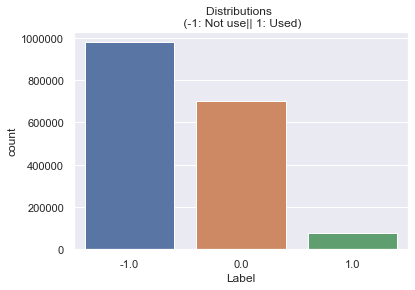

In [218]:
sns.countplot('Label', data=new_df)
plt.title('Distributions \n (-1: Not use|| 1: Used)')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

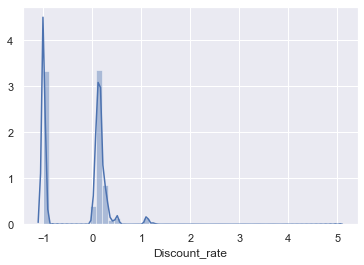

In [219]:
sns.distplot(new_df.Discount_rate)
plt.show

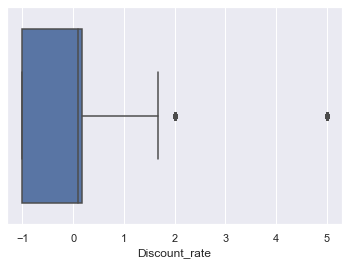

In [220]:
sns.boxplot(new_df.Discount_rate)
plt.show()

In [221]:
new_df.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Label,After_15
0,1439408,2632,NaN,-1.000000,0.0,0.0,0
1,1439408,4663,11002.0,0.133333,1.0,-1.0,0
2,1439408,2632,8591.0,0.050000,0.0,-1.0,0
3,1439408,2632,1078.0,0.050000,0.0,-1.0,0
4,1439408,2632,8591.0,0.050000,0.0,-1.0,0


## 特征工程

# 建模

In [243]:
temp = new_df.drop(new_df[new_df.Label == 0].index, axis=0)

## 特征缩放/归一化
区别不大

In [231]:
scaler = StandardScaler()
temp.User_id = scaler.fit_transform(temp.User_id.values.reshape(-1,1))
temp.Merchant_id = scaler.fit_transform(temp.Merchant_id.values.reshape(-1,1))
temp.Coupon_id = scaler.fit_transform(temp.Coupon_id.values.reshape(-1, 1))

In [236]:
temp.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Label,After_15
1,1439408,4663,11002.0,0.133333,1.0,-1.0,0
2,1439408,2632,8591.0,0.050000,0.0,-1.0,0
3,1439408,2632,1078.0,0.050000,0.0,-1.0,0
4,1439408,2632,8591.0,0.050000,0.0,-1.0,0
6,1439408,2632,8591.0,0.050000,0.0,1.0,1
7,1832624,3381,7610.0,0.100000,0.0,-1.0,0
8,2029232,3381,11951.0,0.100000,1.0,-1.0,0
9,2029232,450,1532.0,0.166667,0.0,-1.0,0
10,2029232,6459,12737.0,0.050000,0.0,-1.0,0
13,2747744,6901,1097.0,0.200000,-1.0,-1.0,0


In [244]:
# Coupon_id作为特征值区别不大，先不用
X = temp.drop(['Label', 'Coupon_id', 'After_15'], axis=1)
y = temp.Label

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=.2, shuffle=True)
X.shape, y.shape, train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((1053282, 4), (1053282,), (842625, 4), (210657, 4), (842625,), (210657,))

In [229]:
log_clf = LogisticRegression(n_jobs=-1, random_state=42)
log_clf.fit(train_X, train_y)

ypred = log_clf.predict(valid_X)
print(classification_report(valid_y, ypred))

              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96    195608
         1.0       0.00      0.00      0.00     15049

    accuracy                           0.93    210657
   macro avg       0.46      0.50      0.48    210657
weighted avg       0.86      0.93      0.89    210657



In [248]:
cross_val_score(log_clf, train_X, train_y, cv=3, verbose=True, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s finished


array([0.928, 0.928, 0.928])

In [266]:
cross_pred = cross_val_predict(log_clf, train_X, train_y, cv=3)

In [269]:
fpr, tpr, thresholds = roc_curve(valid_y, rf_proba[:,1], pos_label=1)

# 优化提升

## 随机森林

In [246]:
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_clf.fit(train_X, train_y)

rf_pred = rf_clf.predict(valid_X)
print(classification_report(valid_y, rf_pred))

              precision    recall  f1-score   support

        -1.0       0.95      0.97      0.96    195637
         1.0       0.46      0.37      0.41     15020

    accuracy                           0.92    210657
   macro avg       0.71      0.67      0.69    210657
weighted avg       0.92      0.92      0.92    210657



In [249]:
rf_proba = rf_clf.predict_proba(valid_X)

In [259]:
rf_proba

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [263]:
rf_proba[(rf_proba[:,1] > 0) & (rf_proba[:,1] < 1)]

array([[0.933, 0.067],
       [0.95 , 0.05 ],
       [0.8  , 0.2  ],
       ...,
       [0.6  , 0.4  ],
       [0.25 , 0.75 ],
       [0.4  , 0.6  ]])

In [269]:
fpr, tpr, thresholds = roc_curve(valid_y, rf_proba[:,1], pos_label=1)

In [270]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

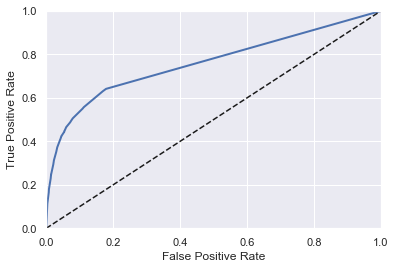

In [271]:
plot_roc_curve(fpr, tpr)
plt.show()

In [272]:
roc_auc_score(valid_y, rf_proba[:,1])

0.7600192081741216

In [278]:
testset = df_test.drop(['Coupon_id', 'Date_received'],axis=1)
testset.head()

,User_id,Merchant_id,Discount_rate,Distance
0,4129537,450,30:5,1.0
1,6949378,1300,30:5,NaN
2,2166529,7113,200:20,5.0
3,2166529,7113,100:10,5.0
4,6172162,7605,30:1,2.0


In [279]:
testset.Discount_rate = testset.Discount_rate.apply(convert_discount_rate)
testset.fillna(-1,inplace=True)

In [281]:
test_proba = rf_clf.predict_proba(testset)

In [283]:
test_proba[:,1]

array([0.195, 0.3  , 0.   , ..., 0.   , 0.   , 0.1  ])

In [291]:
submission = pd.concat([df_test[['User_id', 'Coupon_id', 'Date_received']], 
                        pd.Series(test_proba[:,1])], axis=1)
submission.rename(columns={0: 'Probability'}, inplace=True)
submission.head()

,User_id,Coupon_id,Date_received,Probability
0,4129537,9983,20160712,0.195
1,6949378,3429,20160706,0.300
2,2166529,6928,20160727,0.000
3,2166529,1808,20160727,0.000
4,6172162,6500,20160708,0.000


In [294]:
submission.to_csv('submission/randomforest.csv', header=False, index=False)

## XGBoost

In [194]:
xgb_clf = XGBClassifier(n_jobs=-1, random_state=42)
xgb_clf.fit(train_X, train_y)

xgb_pred = xgb_clf.predict(valid_X)
print(classification_report(valid_y, xgb_pred))

              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96    195547
         1.0       0.00      0.00      0.00     15110

    accuracy                           0.93    210657
   macro avg       0.46      0.50      0.48    210657
weighted avg       0.86      0.93      0.89    210657

